# Figures for Policy Paper Topic 1: Air Pollution
First, let's import our libraries and the file:

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as sm
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
import folium
import io
from PIL import Image


In [3]:
pollution_data = pd.read_csv('QES_AirQuality_data.csv')
pollution_data.head()

,column_label,source,site,code,date,nox,no2,no,ws,wd,air_temp,pm10,pm2_5,v10,v2_5,nv10,nv2_5
0,1,aurn,Cambridge Roadside,CAM,26/06/1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,aurn,Cambridge Roadside,CAM,26/06/1999 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,aurn,Cambridge Roadside,CAM,26/06/1999 02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,aurn,Cambridge Roadside,CAM,26/06/1999 03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,aurn,Cambridge Roadside,CAM,26/06/1999 04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preparation
Now that we have the data imported, let's clean it up a little:

In [4]:
pollution_data['date'] = pollution_data['date'].apply(
    lambda x: x if ' ' in str(x) else x + ' 00:00'
)
pollution_data['date'] = pd.to_datetime(pollution_data['date'], errors='coerce', format='%d/%m/%Y %H:%M')
pollution_data.dtypes

column_label             int64
source                  object
site                    object
code                    object
date            datetime64[ns]
nox                    float64
no2                    float64
no                     float64
ws                     float64
wd                     float64
air_temp               float64
pm10                   float64
pm2_5                  float64
v10                    float64
v2_5                   float64
nv10                   float64
nv2_5                  float64
dtype: object

We will begin by checking that it is statistically sensible to average the data across all locations, for a given time.

In [5]:
# create pivot table to compare sites
site_no = pollution_data.pivot_table(
    index='date',
    columns='site',
    values='no'
)
no_corr_matrix = site_no.corr()

site_no2 = pollution_data.pivot_table(
    index='date',
    columns='site',
    values='no2'
)
no2_corr_matrix = site_no2.corr()

site_pm2_5 = pollution_data.pivot_table(
    index='date',
    columns='site',
    values='pm2_5'
)
pm2_5_corr_matrix = site_pm2_5.corr()

site_pm10 = pollution_data.pivot_table(
    index='date',
    columns='site',
    values='pm10'
)
pm10_corr_matrix = site_pm10.corr()

# Now compute correlations between sites
print(pm10_corr_matrix)
print(pm2_5_corr_matrix)
print(no2_corr_matrix)
print(no_corr_matrix)

site                            Cambridge Gonville Place  \
site                                                       
Cambridge Gonville Place                        1.000000   
Cambridge Gonville Place A603                        NaN   
Cambridge Montague Road                         0.793459   
Cambridge Newmarket Road                        0.426558   
Cambridge Newmarket Road A1134                       NaN   
Cambridge Parker Street                         0.687252   
South Cambs Girton Rd                           0.765047   

site                            Cambridge Gonville Place A603  \
site                                                            
Cambridge Gonville Place                                  NaN   
Cambridge Gonville Place A603                        1.000000   
Cambridge Montague Road                              0.881964   
Cambridge Newmarket Road                                  NaN   
Cambridge Newmarket Road A1134                       0.789020   
Camb

Most sites have correlations $\approx 0.7$ or higher with the exception of Newmarket Road and Newmarket Road A1134, so it seems reasonable to drop those columns and then average the rest considering that atmospheric noise is likely to account for much of the remaining variation. Now let's collate the data by date and check that it is distributed normally:

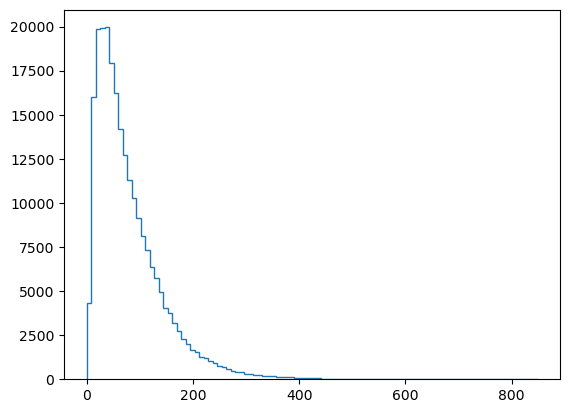

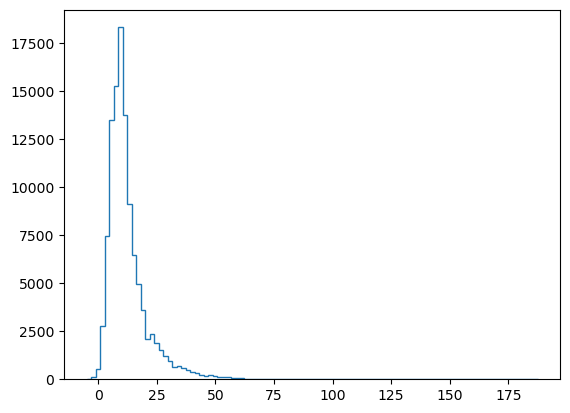

In [6]:
averaged = pollution_data[((pollution_data.site != 'Cambridge Newmarket Road') & (pollution_data.site != 'Cambridge Newmarket Road A1134'))].drop(
    columns=['column_label', 'source', 'site', 'code']).groupby('date').mean()
counts, bins = np.histogram(averaged['nox'].dropna(), bins=100)
plt.stairs(counts, bins)
plt.show()
counts, bins = np.histogram(averaged['pm2_5'].dropna(), bins=100)
plt.stairs(counts, bins)

Now that we know that our data looks reasonable, let's start testing. First, let's look at long-term trends in the data by taking 30-day averages and looking at trends over the years. While we're there, let's also look at trends over the week.

nox              float64
no2              float64
no               float64
ws               float64
wd               float64
air_temp         float64
pm10             float64
pm2_5            float64
v10              float64
v2_5             float64
nv10             float64
nv2_5            float64
hour               int32
day_of_week        int32
uni_term           int64
state_term         int64
private_term       int64
weekday            int64
month              int32
year               int32
time              object
commuter_hour      int64
pm2_5_shifted    float64
dtype: object


<Axes: xlabel='day_of_week', ylabel='pm2_5'>

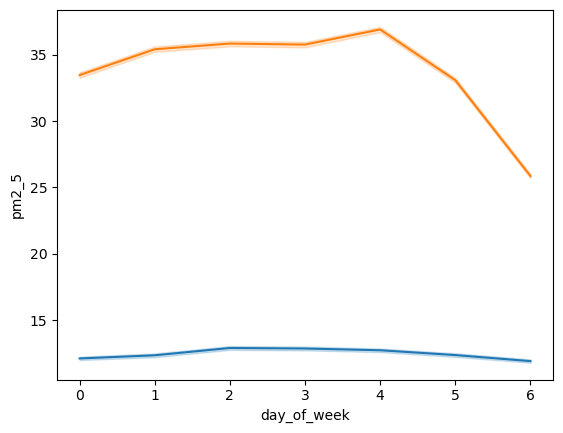

In [55]:
averaged['hour'] = averaged.index.hour
averaged['day_of_week'] = averaged.index.dayofweek
print(averaged.dtypes)

'''
averaged.head()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(data=averaged, x='weekday', y='nox', ax=ax1, legend=False)
ax1.set_xlabel('Day of the week')
ax1.set_ylabel('NOx')
sns.lineplot(data=averaged, x='weekday', y='pm2.5', ax=ax2, legend=False, color='orange')
ax2.set_ylabel('PM2.5')
plt.title('Average Pollution by Day of the Week')
plt.show()

daily_nox = averaged.groupby(averaged.index.date)['nox'].mean()
plt.plot(daily_nox.index, daily_nox.values, alpha=0.3, label='Daily mean')

rm30_no2 = averaged['no2'].rolling(window='30D').mean()
rm30_no2_std = averaged['no2'].rolling(window='30D').mean()
plt.plot(rm30_no2.index, rm30_no2.values, color='red', label='30-day rolling mean')
plt.fill_between(rm30_no2_std.index, 
                 rm30_no2.values - rm30_no2_std.values, 
                 rm30_no2.values + rm30_no2_std.values, 
                 color='red', alpha=0.3, label='±1 std dev')
plt.xlabel('Date')
plt.ylabel('Nitrogen dioxide ($\mu g\: m^{-3}$)')
plt.legend()
plt.title('Daily NO2 Levels in Cambridge with 30-day Rolling Mean')

fig, ax = plt.subplots()
sns.lineplot(data=averaged[averaged.day_of_week < 5], x='hour', y='pm2_5', ax=ax, legend=True, label='weekdays')
sns.lineplot(data=averaged, x='hour', y='pm2_5', ax=ax, legend=True, label='all days')
sns.lineplot(data=averaged[averaged.day_of_week > 4], x='hour', y='pm2_5', ax=ax, legend=True, label='weekends')
ax.set_xlabel('hour of day')
ax.set_xticks(range(0, 24, 2))
ax.set_ylabel('NO2 concentration ($\mu g\: m^{-3}$)')
plt.legend()
plt.title('Average Pollution by Hour of Day')
plt.show()
'''

sns.lineplot(data=averaged, x='day_of_week', y='pm2_5')
sns.lineplot(data=averaged, x='day_of_week', y='no2')

There is a marked drop in NO2 from c. 2017, when, by my research, funding for electric car chargers was first introduced in 2017, as shown in this [September 2017 document](https://democracy.lewes-eastbourne.gov.uk/documents/s25139/Appendix%203%20-%20Electric%20vehicle%20and%20infrastructure%20Strategy%20Cambridge.pdf). Also visible are prominent seasonal variations. *It is also very important to note that the standard deviation is generally very large compared to the mean produced!*

### Next steps
1. Compensate for overall downward trend with a multi-year rolling average
2. (possibly not necessary?) Compensate for seasonal variation by grouping and averaging (I still need to work out exactly what process will be best for this)
3. Correct for commuters by subtracting weekday figures from nearest school holidays?
4. Compare term dates for state & private schools with data, see whether drop in pollution is more pronounced than is proportional to number of number of students attending private when their term finishes. Also check against university term dates.

I've done some research and there may be an elegant way to incorporate all of this into a multiple regression analysis. I think this will be my next step.

Let's get started with this regression analysis. First, we need to make sure we have term dates for all years. This is grunt work, but it is important for the analysis. My sources were the council website, websites for local schools, the university website, and the wayback machine for checking dates which were less recent.

In [8]:
uni_dates = pd.DataFrame(
    {
        "start":[
            "1999-10-05",
            "2000-01-18",
            "2000-04-25",
            
            "2000-10-03",
            "2001-01-16",
            "2001-04-24",
            
            "2001-10-02",
            "2002-01-15",
            "2002-04-23",
            
            "2002-10-08",
            "2003-01-14",
            "2003-04-22",
            
            "2003-10-07",
            "2004-01-13",
            "2004-04-20",
            
            "2004-10-05",
            "2005-01-18",
            "2005-04-26",
            
            "2005-10-04",
            "2006-01-17",
            "2006-04-25",
            
            "2006-10-03",
            "2007-01-16",
            "2007-04-24",
            
            "2007-10-02",
            "2008-01-15",
            "2008-04-22",
            
            "2008-10-07",
            "2009-01-13",
            "2009-04-21",
            
            "2009-10-06",
            "2010-01-12",
            "2010-04-20",
            
            "2010-10-05",
            "2011-01-18",
            "2011-04-26",
            
            "2011-10-04",
            "2012-01-17",
            "2012-04-24",
            
            "2012-10-02",
            "2013-01-15",
            "2013-04-23",
            
            "2013-10-08",
            "2014-01-14",
            "2014-04-21",
            
            "2014-10-07",
            "2015-01-13",
            "2015-04-21",
            
            "2015-10-06",
            "2016-01-12",
            "2016-04-19",
            
            "2016-10-04",
            "2017-01-17",
            "2017-04-25",
            
            "2017-10-03",
            "2018-01-16",
            "2018-04-24",
            
            "2018-10-02",
            "2019-01-15",
            "2019-04-23",
            
            "2019-10-08",
            "2020-01-14",
            "2020-04-21",
            
            "2020-10-06",
            "2021-01-19",
            "2021-04-27",
            
            "2021-10-05",
            "2022-01-18",
            "2022-04-26",
            
            "2022-10-04",
            "2023-01-17",
            "2023-04-25",
            
            "2023-10-03",
            "2024-01-16",
            "2024-04-23",
            
            "2024-10-08",
            "2025-01-21",
            "2025-04-29",
        ],
        "end":["1999-12-03",
            "2000-03-17",
            "2000-06-16",
            
            "2000-12-01",
            "2001-03-16",
            "2001-06-15",
            
            "2001-12-07",
            "2002-03-15",
            "2002-06-14",
            
            "2002-12-06",
            "2003-03-14",
            "2003-06-13",
            
            "2003-12-05",
            "2004-03-12",
            "2004-06-11",
            
            "2004-12-03",
            "2005-03-18",
            "2005-06-17",
            
            "2005-12-02",
            "2006-03-17",
            "2006-06-16",
            
            "2006-12-01",
            "2007-03-16",
            "2007-06-15",
            
            "2007-11-30",
            "2008-03-14",
            "2008-06-13",
            
            "2008-12-05",
            "2009-03-13",
            "2009-06-12",
            
            "2009-12-04",
            "2010-03-12",
            "2010-06-11",
            
            "2010-12-03",
            "2011-03-18",
            "2011-06-17",
            
            "2011-11-02",
            "2012-03-16",
            "2012-06-15",
            
            "2012-11-30",
            "2013-03-15",
            "2013-06-14",
            
            "2013-12-06",
            "2014-03-14",
            "2014-06-13",
            
            "2014-12-05",
            "2015-03-13",
            "2015-06-12",
            
            "2015-12-04",
            "2016-03-11",
            "2016-06-10",
            
            "2016-12-02",
            "2017-03-17",
            "2017-06-16",
            
            "2017-12-01",
            "2018-03-16",
            "2018-06-15",
            
            "2018-11-30",
            "2019-03-15",
            "2019-06-14",
            
            "2019-12-06",
            "2020-03-13",
            "2020-06-12",
            
            "2020-12-04",
            "2021-03-19",
            "2021-06-18",
            
            "2021-12-03",
            "2022-03-18",
            "2022-06-17",
            
            "2022-12-02",
            "2023-03-17",
            "2023-06-16",
            
            "2023-12-01",
            "2024-03-15",
            "2024-06-14",
            
            "2024-12-06",
            "2025-03-21",
            "2025-06-20",
        ] 
    }
)
uni_dates["start"] = pd.to_datetime(uni_dates["start"])
uni_dates["end"] = pd.to_datetime(uni_dates["end"])
state_dates = pd.DataFrame(
    {
        "start":[# 1999-2000 (ESTIMATED)
            "1999-09-07",  # Early September (Tuesday following Labour Day)
            "2000-01-04",  # Early January (Tuesday)
            "2000-04-18",  # Mid-April (Tuesday)
            
            # 2000-2001 (ESTIMATED)
            "2000-09-05",  # Early September
            "2001-01-02",  # Early January
            "2001-04-17",  # Mid-April
            
            # 2001-2002 (ESTIMATED based on Norfolk similar dates)
            "2001-09-04",  # Early September
            "2002-01-08",  # Early January
            "2002-04-16",  # Mid-April
            
            # 2002-2003 (ESTIMATED)
            "2002-09-03",  # Early September
            "2003-01-07",  # Early January
            "2003-04-15",  # Mid-April
            
            # 2003-2004 (ESTIMATED)
            "2003-09-02",  # Early September
            "2004-01-06",  # Early January
            "2004-04-20",  # Mid-April
            
            # 2004-2005 (ESTIMATED)
            "2004-09-07",  # Early September
            "2005-01-04",  # Early January
            "2005-04-19",  # Mid-April
            
            # 2005-2006 (ESTIMATED based on 2006+ pattern)
            "2005-09-06",
            "2006-01-03",
            "2006-04-18",
            
            # 2006-2007 (CONFIRMED PATTERN)
            "2006-09-05",
            "2007-01-08",
            "2007-04-17",
            
            # 2007-2008 (CONFIRMED)
            "2007-09-04",
            "2008-01-07",
            "2008-04-21",
            
            # 2008-2009 (CONFIRMED)
            "2008-09-02",
            "2009-01-05",
            "2009-04-20",
            
            # 2009-2010 (CONFIRMED)
            "2009-09-01",
            "2010-01-04",
            "2010-04-19",
            
            # 2010-2011 (CONFIRMED)
            "2010-09-07",
            "2011-01-03",
            "2011-04-25",
            
            # 2011-2012 (CONFIRMED)
            "2011-09-06",
            "2012-01-03",
            "2012-04-16",
            
            # 2012-2013 (CONFIRMED)
            "2012-09-04",
            "2013-01-08",
            "2013-04-15",
            
            # 2013-2014 (CONFIRMED)
            "2013-09-04",
            "2014-01-07",
            "2014-04-22",
            
            # 2014-2015 (CONFIRMED)
            "2014-09-02",
            "2015-01-05",
            "2015-04-13",
            
            # 2015-2016 (CONFIRMED)
            "2015-09-01",
            "2016-01-04",
            "2016-04-18",
            
            # 2016-2017 (CONFIRMED)
            "2016-09-06",
            "2017-01-09",
            "2017-04-17",
            
            # 2017-2018 (CONFIRMED)
            "2017-09-05",
            "2018-01-08",
            "2018-04-23",
            
            # 2018-2019 (CONFIRMED)
            "2018-09-04",
            "2019-01-07",
            "2019-04-22",
            
            # 2019-2020 (CONFIRMED)
            "2019-09-03",
            "2020-01-06",
            "2020-04-20",
            
            # 2020-2021 (CONFIRMED)
            "2020-09-01",
            "2021-01-04",
            "2021-04-19",
            
            # 2021-2022 (CONFIRMED)
            "2021-09-06",
            "2022-01-03",
            "2022-04-25",
            
            # 2022-2023 (CONFIRMED)
            "2022-09-05",
            "2023-01-09",
            "2023-04-17",
            
            # 2023-2024 (CONFIRMED)
            "2023-09-05",
            "2024-01-08",
            "2024-04-22",
            
            # 2024-2025 (CONFIRMED)
            "2024-09-03",
            "2025-01-06",
            "2025-04-21"
        ],
        "end":[# 1999-2000 (ESTIMATED - ends before Christmas, Easter, Summer holidays)
            "1999-12-22",  # Mid-December (before Christmas break)
            "2000-03-31",  # Late March (Easter term end)
            "2000-07-21",  # Late July (Summer holiday begins)
            
            # 2000-2001 (ESTIMATED)
            "2000-12-21",
            "2001-03-30",
            "2001-07-20",
            
            # 2001-2002 (ESTIMATED)
            "2001-12-21",
            "2002-03-29",
            "2002-07-19",
            
            # 2002-2003 (ESTIMATED)
            "2002-12-20",
            "2003-03-28",
            "2003-07-18",
            
            # 2003-2004 (ESTIMATED)
            "2003-12-19",
            "2004-04-02",
            "2004-07-23",
            
            # 2004-2005 (ESTIMATED)
            "2004-12-17",
            "2005-04-01",
            "2005-07-22",
            
            # 2005-2006 (ESTIMATED based on 2006+ pattern)
            "2005-12-16",
            "2006-03-31",
            "2006-07-21",
            
            # 2006-2007 (CONFIRMED PATTERN)
            "2006-12-22",
            "2007-03-30",
            "2007-07-20",
            
            # 2007-2008 (CONFIRMED)
            "2007-12-21",
            "2008-03-28",
            "2008-07-18",
            
            # 2008-2009 (CONFIRMED)
            "2008-12-19",
            "2009-03-27",
            "2009-07-17",
            
            # 2009-2010 (CONFIRMED)
            "2009-12-18",
            "2010-03-26",
            "2010-07-16",
            
            # 2010-2011 (CONFIRMED)
            "2010-12-17",
            "2011-03-25",
            "2011-07-22",
            
            # 2011-2012 (CONFIRMED)
            "2011-12-16",
            "2012-03-30",
            "2012-07-20",
            
            # 2012-2013 (CONFIRMED)
            "2012-12-21",
            "2013-03-28",
            "2013-07-23",
            
            # 2013-2014 (CONFIRMED)
            "2013-12-20",
            "2014-04-04",
            "2014-07-23",
            
            # 2014-2015 (CONFIRMED)
            "2014-12-19",
            "2015-04-03",
            "2015-07-24",
            
            # 2015-2016 (CONFIRMED)
            "2015-12-18",
            "2016-04-01",
            "2016-07-22",
            
            # 2016-2017 (CONFIRMED)
            "2016-12-16",
            "2017-04-07",
            "2017-07-21",
            
            # 2017-2018 (CONFIRMED)
            "2017-12-22",
            "2018-04-06",
            "2018-07-20",
            
            # 2018-2019 (CONFIRMED)
            "2018-12-21",
            "2019-04-05",
            "2019-07-19",
            
            # 2019-2020 (CONFIRMED)
            "2019-12-20",
            "2020-04-03",
            "2020-07-17",
            
            # 2020-2021 (CONFIRMED)
            "2020-12-18",
            "2021-04-02",
            "2021-07-16",
            
            # 2021-2022 (CONFIRMED)
            "2021-12-17",
            "2022-04-01",
            "2022-07-22",
            
            # 2022-2023 (CONFIRMED)
            "2022-12-16",
            "2023-03-31",
            "2023-07-21",
            
            # 2023-2024 (CONFIRMED)
            "2023-12-22",
            "2024-03-29",
            "2024-07-19",
            
            # 2024-2025 (CONFIRMED)
            "2024-12-20",
            "2025-04-04",
            "2025-07-18",
        ]    
    }
)
state_dates["start"] = pd.to_datetime(state_dates["start"])
state_dates["end"] = pd.to_datetime(state_dates["end"])
# Based on analysis of major Cambridge independent schools:
    # - The Perse School
    # - Sancton Wood School  
    # - St Faith's Cambridge
    # - Stephen Perse Foundation
    # - Cambridge International School
private_dates = pd.DataFrame(
    {
        "start":[# 1999-2000 (ESTIMATED based on established patterns)
            "1999-09-03",  # Michaelmas (Friday in first full week)
            "2000-01-05",  # Lent (Wednesday)
            "2000-04-17",  # Summer (Monday)
            
            # 2000-2001
            "2000-09-01",  # Michaelmas (Friday)
            "2001-01-03",  # Lent (Wednesday)
            "2001-04-16",  # Summer (Monday)
            
            # 2001-2002
            "2001-09-07",  # Michaelmas (Friday)
            "2002-01-09",  # Lent (Wednesday)
            "2002-04-15",  # Summer (Monday)
            
            # 2002-2003
            "2002-09-06",  # Michaelmas (Friday)
            "2003-01-08",  # Lent (Wednesday)
            "2003-04-21",  # Summer (Monday)
            
            # 2003-2004
            "2003-09-05",  # Michaelmas (Friday)
            "2004-01-07",  # Lent (Wednesday)
            "2004-04-19",  # Summer (Monday)
            
            # 2004-2005
            "2004-09-03",  # Michaelmas (Friday)
            "2005-01-05",  # Lent (Wednesday)
            "2005-04-18",  # Summer (Monday)
            
            # 2005-2006
            "2005-09-02",  # Michaelmas (Friday)
            "2006-01-04",  # Lent (Wednesday)
            "2006-04-17",  # Summer (Monday)
            
            # 2006-2007
            "2006-09-01",  # Michaelmas (Friday)
            "2007-01-03",  # Lent (Wednesday)
            "2007-04-16",  # Summer (Monday)
            
            # 2007-2008
            "2007-09-07",  # Michaelmas (Friday)
            "2008-01-09",  # Lent (Wednesday)
            "2008-04-21",  # Summer (Monday)
            
            # 2008-2009
            "2008-09-05",  # Michaelmas (Friday)
            "2009-01-07",  # Lent (Wednesday)
            "2009-04-20",  # Summer (Monday)
            
            # 2009-2010
            "2009-09-04",  # Michaelmas (Friday)
            "2010-01-06",  # Lent (Wednesday)
            "2010-04-19",  # Summer (Monday)
            
            # 2010-2011
            "2010-09-03",  # Michaelmas (Friday)
            "2011-01-05",  # Lent (Wednesday)
            "2011-04-18",  # Summer (Monday)
            
            # 2011-2012
            "2011-09-02",  # Michaelmas (Friday)
            "2012-01-04",  # Lent (Wednesday)
            "2012-04-16",  # Summer (Monday)
            
            # 2012-2013
            "2012-09-07",  # Michaelmas (Friday)
            "2013-01-09",  # Lent (Wednesday)
            "2013-04-15",  # Summer (Monday)
            
            # 2013-2014
            "2013-09-06",  # Michaelmas (Friday)
            "2014-01-08",  # Lent (Wednesday)
            "2014-04-21",  # Summer (Monday)
            
            # 2014-2015
            "2014-09-05",  # Michaelmas (Friday)
            "2015-01-07",  # Lent (Wednesday)
            "2015-04-20",  # Summer (Monday)
            
            # 2015-2016
            "2015-09-04",  # Michaelmas (Friday)
            "2016-01-06",  # Lent (Wednesday)
            "2016-04-18",  # Summer (Monday)
            
            # 2016-2017
            "2016-09-02",  # Michaelmas (Friday)
            "2017-01-04",  # Lent (Wednesday)
            "2017-04-17",  # Summer (Monday)
            
            # 2017-2018
            "2017-09-01",  # Michaelmas (Friday)
            "2018-01-03",  # Lent (Wednesday)
            "2018-04-16",  # Summer (Monday)
            
            # 2018-2019
            "2018-09-07",  # Michaelmas (Friday)
            "2019-01-09",  # Lent (Wednesday)
            "2019-04-15",  # Summer (Monday)
            
            # 2019-2020
            "2019-09-06",  # Michaelmas (Friday)
            "2020-01-08",  # Lent (Wednesday)
            "2020-04-20",  # Summer (Monday)
            
            # 2020-2021
            "2020-09-04",  # Michaelmas (Friday)
            "2021-01-06",  # Lent (Wednesday)
            "2021-04-19",  # Summer (Monday)
            
            # 2021-2022 (CONFIRMED from school websites)
            "2021-09-03",  # Michaelmas (Friday)
            "2022-01-05",  # Lent (Wednesday)
            "2022-04-18",  # Summer (Monday)
            
            # 2022-2023
            "2022-09-02",  # Michaelmas (Friday)
            "2023-01-04",  # Lent (Wednesday)
            "2023-04-17",  # Summer (Monday)
            
            # 2023-2024
            "2023-09-01",  # Michaelmas (Friday)
            "2024-01-03",  # Lent (Wednesday)
            "2024-04-15",  # Summer (Monday)
            
            # 2024-2025 (CONFIRMED from official school websites)
            "2024-09-03",  # Michaelmas (Tuesday/Wednesday typically)
            "2025-01-06",  # Lent (Tuesday/Wednesday)
            "2025-04-21",  # Summer (Monday/Tuesday)
        ],
        "end":[ # 1999-2000 (ESTIMATED)
            "1999-12-10",  # Michaelmas ends (Friday before Christmas)
            "2000-03-24",  # Lent ends (Friday before Easter holidays)
            "2000-07-07",  # Summer ends (Friday)
            
            # 2000-2001
            "2000-12-08",  # Michaelmas ends
            "2001-03-23",  # Lent ends
            "2001-07-06",  # Summer ends
            
            # 2001-2002
            "2001-12-14",  # Michaelmas ends
            "2002-03-22",  # Lent ends
            "2002-07-05",  # Summer ends
            
            # 2002-2003
            "2002-12-13",  # Michaelmas ends
            "2003-03-21",  # Lent ends
            "2003-07-04",  # Summer ends
            
            # 2003-2004
            "2003-12-12",  # Michaelmas ends
            "2004-03-26",  # Lent ends
            "2004-07-09",  # Summer ends
            
            # 2004-2005
            "2004-12-10",  # Michaelmas ends
            "2005-03-25",  # Lent ends
            "2005-07-08",  # Summer ends
            
            # 2005-2006
            "2005-12-09",  # Michaelmas ends
            "2006-03-24",  # Lent ends
            "2006-07-07",  # Summer ends
            
            # 2006-2007
            "2006-12-08",  # Michaelmas ends
            "2007-03-23",  # Lent ends
            "2007-07-06",  # Summer ends
            
            # 2007-2008
            "2007-12-14",  # Michaelmas ends
            "2008-03-28",  # Lent ends (Easter late)
            "2008-07-11",  # Summer ends
            
            # 2008-2009
            "2008-12-12",  # Michaelmas ends
            "2009-03-27",  # Lent ends
            "2009-07-10",  # Summer ends
            
            # 2009-2010
            "2009-12-11",  # Michaelmas ends
            "2010-03-26",  # Lent ends
            "2010-07-09",  # Summer ends
            
            # 2010-2011
            "2010-12-10",  # Michaelmas ends
            "2011-03-25",  # Lent ends
            "2011-07-08",  # Summer ends
            
            # 2011-2012
            "2011-12-09",  # Michaelmas ends
            "2012-03-23",  # Lent ends
            "2012-07-06",  # Summer ends
            
            # 2012-2013
            "2012-12-14",  # Michaelmas ends
            "2013-03-29",  # Lent ends
            "2013-07-12",  # Summer ends
            
            # 2013-2014
            "2013-12-13",  # Michaelmas ends
            "2014-03-28",  # Lent ends
            "2014-07-11",  # Summer ends
            
            # 2014-2015
            "2014-12-12",  # Michaelmas ends
            "2015-03-27",  # Lent ends
            "2015-07-10",  # Summer ends
            
            # 2015-2016
            "2015-12-11",  # Michaelmas ends
            "2016-03-25",  # Lent ends
            "2016-07-08",  # Summer ends
            
            # 2016-2017
            "2016-12-09",  # Michaelmas ends
            "2017-03-24",  # Lent ends
            "2017-07-07",  # Summer ends
            
            # 2017-2018
            "2017-12-08",  # Michaelmas ends
            "2018-03-23",  # Lent ends
            "2018-07-06",  # Summer ends
            
            # 2018-2019
            "2018-12-14",  # Michaelmas ends
            "2019-03-29",  # Lent ends
            "2019-07-12",  # Summer ends
            
            # 2019-2020
            "2019-12-13",  # Michaelmas ends
            "2020-03-27",  # Lent ends
            "2020-07-10",  # Summer ends
            
            # 2020-2021
            "2020-12-11",  # Michaelmas ends
            "2021-03-26",  # Lent ends
            "2021-07-09",  # Summer ends
            
            # 2021-2022 (CONFIRMED from school websites)
            "2021-12-10",  # Michaelmas ends (Friday)
            "2022-03-25",  # Lent ends (Friday)
            "2022-07-08",  # Summer ends (Friday)
            
            # 2022-2023
            "2022-12-09",  # Michaelmas ends (Friday)
            "2023-03-24",  # Lent ends (Friday)
            "2023-07-07",  # Summer ends (Friday)
            
            # 2023-2024
            "2023-12-08",  # Michaelmas ends (Friday)
            "2024-03-29",  # Lent ends (Friday)
            "2024-07-12",  # Summer ends (Friday)
            
            # 2024-2025 (CONFIRMED from official school websites)
            "2024-12-13",  # Michaelmas ends (Friday/Thursday)
            "2025-03-28",  # Lent ends (Friday)
            "2025-07-04",  # Summer ends (Friday)
        ]
    }
)
private_dates["start"] = pd.to_datetime(private_dates["start"])
private_dates["end"] = pd.to_datetime(private_dates["end"])


With all of this data in (God, that took a while...) we can begin with our analysis! First, we need to assign each date as in or out of each type of term (while we're here, I'm also going to drop the data pre-start of Michaelmas term 1999, and post-Easter 2025, since I don't have the school dates to go with it):

In [9]:
# Drop data outside known term dates
averaged = averaged[averaged.index >= pd.to_datetime('1999-09-07')]
averaged = averaged[averaged.index <= pd.to_datetime('2025-09-01')]

# Define a function to test if a date is in a given institution's terms
def check_in_term(dates, ranges): # This is vectorised to save time
    in_term = np.zeros(len(dates), dtype=int)
    for _, row in ranges.iterrows():
        in_term[(dates >= row['start']) & (dates <= row['end'])] = 1
    return in_term

# Produce boolean arrays for each date using the function above
averaged['uni_term'] = check_in_term(averaged.index, uni_dates) # 1 for in term, 0 for out of term
averaged['state_term'] = check_in_term(averaged.index, state_dates) # etc.
averaged['private_term'] = check_in_term(averaged.index, private_dates)

# Add month and year columns for regression analysis
averaged['day_of_week'] = averaged.index.dayofweek
averaged['weekday'] = (averaged['day_of_week'] < 5).astype(int) # 1 for Mon-Fri, 0 for Sat-Sun
averaged['month'] = averaged.index.month
averaged['year'] = averaged.index.year
averaged['time'] = averaged.index.time

# Check if commutes/school runs are occurring (6-9am and 4-7pm on weekdays)
averaged['commuter_hour'] = np.zeros(len(averaged.index), dtype=int)
averaged.loc[(((averaged.index.hour >= 6) & (averaged.index.hour <= 9)) | 
                  ((averaged.index.hour >= 16) & (averaged.index.hour <= 19))) & averaged.weekday, 'commuter_hour'] = 1

averaged.iloc[24*5+8, :]


nox                  27.0
no2                  11.0
no                   10.0
ws                    NaN
wd                    NaN
air_temp              NaN
pm10                 25.0
pm2_5                 NaN
v10                   NaN
v2_5                  NaN
nv10                  NaN
nv2_5                 NaN
hour                    8
day_of_week             6
uni_term                0
state_term              1
private_term            1
weekday                 0
month                   9
year                 1999
time             08:00:00
commuter_hour           0
Name: 1999-09-12 08:00:00, dtype: object

## Data Analysis
Now we can begin the fun part: actually analysing the data. We'll first perform some variance inflation factor (VIF) testing for multicollinearity, some of which is likely to be present among the variables.

In [10]:
vif_data = pd.DataFrame()
X = averaged[['uni_term', 'state_term', 'air_temp', 'ws']]
X_clean = X.replace(np.nan).dropna()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]
print("Variance Inflation Factors (VIF):")
print(vif_data)

C:\Users\fredd\AppData\Local\Temp\ipykernel_109772\2958736232.py:3: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  X_clean = X.replace(np.nan).dropna()


Variance Inflation Factors (VIF):
     Variable       VIF
0    uni_term  2.566707
1  state_term  4.315095
2    air_temp  2.668810
3          ws  3.493985


It looks like our variance inflation factors are all <5, which is a good sign! I've excluded `private_term` as it would artificially inflate the VIFs by virtue of its close correlation with `state_term`.

First, let's calculate our significance threshold:

In [21]:
sig_threshold_no2 = 0.05 * np.sqrt(100 / len(averaged.no2.notna()))  # Adjusted significance threshold for NO2
sig_threshold_pm2_5 = 0.05 * np.sqrt(100 / len(averaged.pm2_5.notna()))  # Adjusted significance threshold for NO2
print(f"p-value of {sig_threshold_no2:.4f} for NO2 is considered significant.")
print(f"p-value of {sig_threshold_pm2_5:.4f} for PM2.5 is considered significant.")

p-value of 0.0010 for NO2 is considered significant.
p-value of 0.0010 for PM2.5 is considered significant.


Now let's run this regression, first trying out NO2 and PM10 as our pollutant:

In [97]:
no2_formula = '''
no2 ~ 
    uni_term + 
    state_term + 
    private_term +
    weekday + 
    commuter_hour +
    air_temp + 
    I(air_temp**2) + 
    ws + 
    wd +
    C(hour) +
    C(month) + 
    C(year)
'''

 # Non-linear weather effects included via temperature squared term
 # Monthly fixed effects and long-term trends encapsulated by month and year

# Backwards Stepwise Elimination function to build a minimal model
def bse(formula, data, sl=0.05, verbose=True):
    y_var, X_part = formula.split('~')
    y_var = y_var.strip()
    terms = [t.strip() for t in X_part.split('+') if t.strip()]

    while True:
        current_formula = y_var + ' ~ ' + ' + '.join(terms)
        model = sm.ols(current_formula, data=data).fit(cov_type='HC0')  # Using robust standard errors in case of heteroscedasticity

        # p‑values excluding intercept
        pvals = model.pvalues.drop('Intercept', errors='ignore')

        # find worst (largest) p‑value
        worst_term = pvals.idxmax()
        worst_p = pvals.max()

        if verbose:
            print(f"\nCurrent formula: {current_formula}")
            print(f"Worst term: {worst_term}  p = {worst_p:.4f}")

        # stop if all below threshold
        if worst_p < sl:
            break

        # drop whole factor for categorical terms like C(month)[T.2]
        base = re.split(r'\[', worst_term)[0]
        terms = [t for t in terms if base not in t]

        if verbose:
            print(f"  -> Dropping: {base}")

        if not terms:
            break

    if verbose:
        print("\nFinal minimal model formula:")
        print(current_formula)
        print(model.summary())

    return model, current_formula

no2_model, no2_min_formula = bse(no2_formula, averaged, sig_threshold_no2)

print("\n" + "="*60)
print("NO2 REGRESSION RESULTS SUMMARY")
print("="*60)
print(f"R-squared: {no2_model.rsquared:.4f}  (explains {no2_model.rsquared*100:.1f}% of variance)")
print(f"Adjusted R-squared: {no2_model.rsquared_adj:.4f}")
print(f"F-statistic: {no2_model.fvalue:.2f} (p-value < 0.001)")

print("\nCoefficients for Key Factors:")
# print(f"University Term:        β = {no2_model.params['uni_term']:+.3f} µg/m³")
# print(f"  95% CI: [{no2_model.conf_int().loc['uni_term', 0]:+.3f}, {no2_model.conf_int().loc['uni_term', 1]:+.3f}]")
# print(f"  p-value: {no2_model.pvalues['uni_term']:.3f}")

print(f"\nState School Term:    β = {no2_model.params['state_term']:+.3f} µg/m³")
print(f"  95% CI: [{no2_model.conf_int().loc['state_term', 0]:+.3f}, {no2_model.conf_int().loc['state_term', 1]:+.3f}]")
print(f"  p-value: {no2_model.pvalues['state_term']:.2e}")

print(f"\nPrivate School Term:  β = {no2_model.params['private_term']:+.3f} µg/m³")
print(f"  95% CI: [{no2_model.conf_int().loc['private_term', 0]:+.3f}, {no2_model.conf_int().loc['private_term', 1]:+.3f}]")
print(f"  p-value: {no2_model.pvalues['private_term']:.2e}")

print(f"\nWeekday Effect:        β = {no2_model.params['weekday']:+.3f} µg/m³")
print(f"  95% CI: [{no2_model.conf_int().loc['weekday', 0]:+.3f}, {no2_model.conf_int().loc['weekday', 1]:+.3f}]")
print(f"  p-value: {no2_model.pvalues['weekday']:.2e}")

print(f"\nCommuter Hour Effect:   β = {no2_model.params['commuter_hour']:+.3f} µg/m³")
print(f"  95% CI: [{no2_model.conf_int().loc['commuter_hour', 0]:+.3f}, {no2_model.conf_int().loc['commuter_hour', 1]:+.3f}]")
print(f"  p-value: {no2_model.pvalues['commuter_hour']:.2e}")

averaged.pm2_5_shifted = averaged.pm2_5.shift(-2)

pm2_5_formula = '''
pm2_5_shifted ~ 
    uni_term + 
    state_term + 
    private_term +
    weekday + 
    commuter_hour +
    air_temp + 
    I(air_temp**2) + 
    ws + 
    wd +
    C(hour) +
    C(month) + 
    C(year)
'''

pm2_5_model, pm2_5_min_formula = bse(pm2_5_formula, averaged, sig_threshold_pm2_5)

print("\n" + "="*60)
print("PM2.5 REGRESSION RESULTS SUMMARY")
print("="*60)
print(f"R-squared: {pm2_5_model.rsquared:.4f}  (explains {pm2_5_model.rsquared*100:.1f}% of variance)")
print(f"Adjusted R-squared: {pm2_5_model.rsquared_adj:.4f}")
print(f"F-statistic: {pm2_5_model.fvalue:.2f} (p-value < 0.001)")

print("\nCoefficients for Key Factors:")
# print(f"University Term:        β = {pm2_5_model.params['uni_term']:+.3f} µg/m³")
# print(f"  95% CI: [{pm2_5_model.conf_int().loc['uni_term', 0]:+.3f}, {pm2_5_model.conf_int().loc['uni_term', 1]:+.3f}]")
# print(f"  p-value: {pm2_5_model.pvalues['uni_term']:.3f}")

print(f"\nState School Term:    β = {pm2_5_model.params['state_term']:+.3f} µg/m³")
print(f"  95% CI: [{pm2_5_model.conf_int().loc['state_term', 0]:+.3f}, {pm2_5_model.conf_int().loc['state_term', 1]:+.3f}]")
print(f"  p-value: {pm2_5_model.pvalues['state_term']:.2e}")

print(f"\nPrivate School Term:  β = {pm2_5_model.params['private_term']:+.3f} µg/m³")
print(f"  95% CI: [{pm2_5_model.conf_int().loc['private_term', 0]:+.3f}, {pm2_5_model.conf_int().loc['private_term', 1]:+.3f}]")
print(f"  p-value: {pm2_5_model.pvalues['private_term']:.2e}")

# print(f"\nWeekday Effect:        β = {pm2_5_model.params['weekday']:+.3f} µg/m³")
# print(f"  95% CI: [{pm2_5_model.conf_int().loc['weekday', 0]:+.3f}, {pm2_5_model.conf_int().loc['weekday', 1]:+.3f}]")
# print(f"  p-value: {pm2_5_model.pvalues['weekday']:.2e}")


Current formula: no2 ~ uni_term + state_term + private_term + weekday + commuter_hour + air_temp + I(air_temp**2) + ws + wd + C(hour) + C(month) + C(year)
Worst term: uni_term  p = 0.3311
  -> Dropping: uni_term

Current formula: no2 ~ state_term + private_term + weekday + commuter_hour + air_temp + I(air_temp**2) + ws + wd + C(hour) + C(month) + C(year)
Worst term: C(year)[T.2004]  p = 0.0002

Final minimal model formula:
no2 ~ state_term + private_term + weekday + commuter_hour + air_temp + I(air_temp**2) + ws + wd + C(hour) + C(month) + C(year)


c:\Users\fredd\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 68, but rank is 58
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                 2.140e+04
Date:                Tue, 03 Feb 2026   Prob (F-statistic):               0.00
Time:                        14:38:58   Log-Likelihood:            -4.7488e+05
No. Observations:              129052   AIC:                         9.499e+05
Df Residuals:                  128994   BIC:                         9.504e+05
Df Model:                          57                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           31.4385      0.203  

I tested all pollutants, but have left two in the code here as examples. It is trivial to rewrite the code to test for other pollutants, if you, dear Reader, wish to do so. NO2 displays the highest $R^{2}$ value, so going forward we will use it for our analysis and visualisation. The low $R{^2}$ value for the aerosol pollutants measured is likely due to the timescale of their lifecycle causing a delay between emission and the rise in levels. This can probably be corrected by offsetting commute times compared to emissions data, accounting for the delay. Visualisation will help.
It is also worth noting that by its p-value of 0.331 (and noting the 95% confidence interval includes both positive and negative values), we can conclude that there is insufficient evidence to reject the null hypothesis with regards to the effect of University of Cambridge term on NO2 emissions.

## Data Visualisation

I would like to start by comparing NO2 over the day *during weekdays* for private school term, state school term and no term at all.

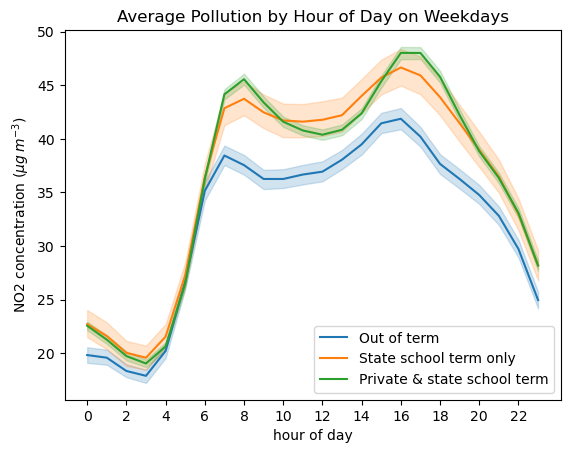

In [100]:
fig, ax = plt.subplots()

sns.lineplot(data=averaged.loc[((averaged.weekday == 1) & (averaged.state_term == 0))], x='hour', y='no2', ax=ax, legend=True, label='Out of term')
sns.lineplot(data=averaged.loc[((averaged.weekday == 1) & (averaged.state_term == 1) & (averaged.private_term==0))], x='hour', y='no2', ax=ax, legend=True, label='State school term only')
sns.lineplot(data=averaged.loc[((averaged.weekday == 1) & (averaged.private_term == 1) & (averaged.state_term == 1))], x='hour', y='no2', ax=ax, legend=True, label='Private & state school term')

ax.set_xlabel('hour of day')
ax.set_xticks(range(0, 24, 2))
ax.set_ylabel('NO2 concentration ($\mu g\: m^{-3}$)')
plt.legend()
plt.title('Average Pollution by Hour of Day on Weekdays')
plt.show()

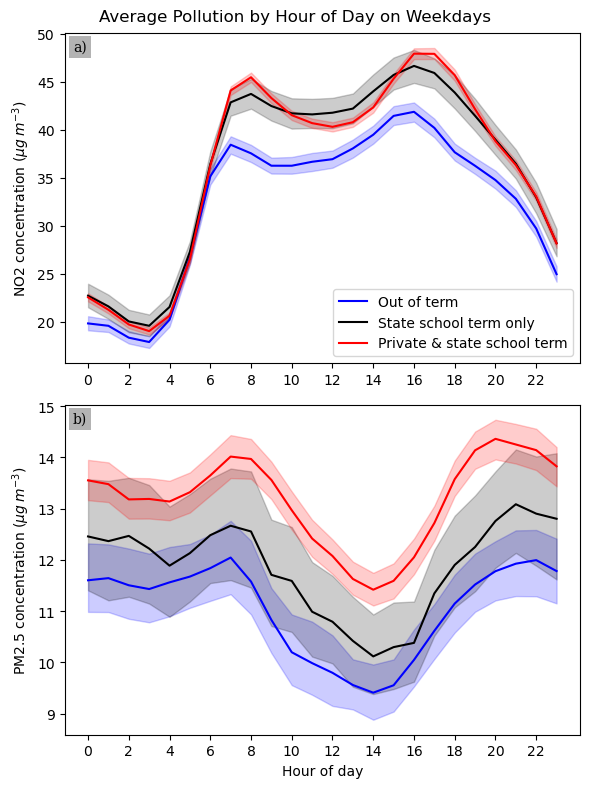

In [103]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 8))

# This figure is included in the report.
sns.lineplot(data=averaged[((averaged.weekday == 1) & (averaged.state_term == 0))], x='hour', y='no2', ax=ax1, legend=True, color='blue', label='Out of term')
sns.lineplot(data=averaged[((averaged.weekday == 1) & (averaged.state_term == 1) & (averaged.private_term==0))], x='hour', y='no2', ax=ax1, legend=True, color='black', label='State school term only')
sns.lineplot(data=averaged[((averaged.weekday == 1) & (averaged.private_term == 1))], x='hour', y='no2', ax=ax1, legend=True, color='red', label='Private & state school term')

sns.lineplot(data=averaged[((averaged.weekday == 1) & (averaged.state_term == 0))], x='hour', y='pm2_5', ax=ax2, color='blue', legend=False)
sns.lineplot(data=averaged[((averaged.weekday == 1) & (averaged.state_term == 1) & (averaged.private_term==0))], x='hour', y='pm2_5', ax=ax2, color='black', legend=False)
sns.lineplot(data=averaged[((averaged.weekday == 1) & (averaged.private_term == 1))], x='hour', y='pm2_5', ax=ax2, color='red', legend=False)

ax1.set(xlabel=None, ylabel='NO2 concentration ($\mu g\: m^{-3}$)')
ax1.set_xticks(range(0, 24, 2))
ax1.legend(loc='best')
ax1.annotate(
    "a)",
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.6, -0.5), textcoords='offset fontsize',
    fontsize='medium', verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

ax2.set(xlabel='Hour of day', ylabel='PM2.5 concentration ($\mu g\: m^{-3}$)')
ax2.set_xticks(range(0, 24, 2))
ax2.annotate(
    "b)",
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.6, -0.5), textcoords='offset fontsize',
    fontsize='medium', verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Average Pollution by Hour of Day on Weekdays')
plt.show()
fig.savefig('hourly_pollutants.svg', format='svg')

Now let's generate the second plot, a 365-day rolling average to average out seasonal variability and look at the long-term effects of policy changes: (I will take only the data from 9AM each day to avoid the std-inflating effect of changes over a single day).

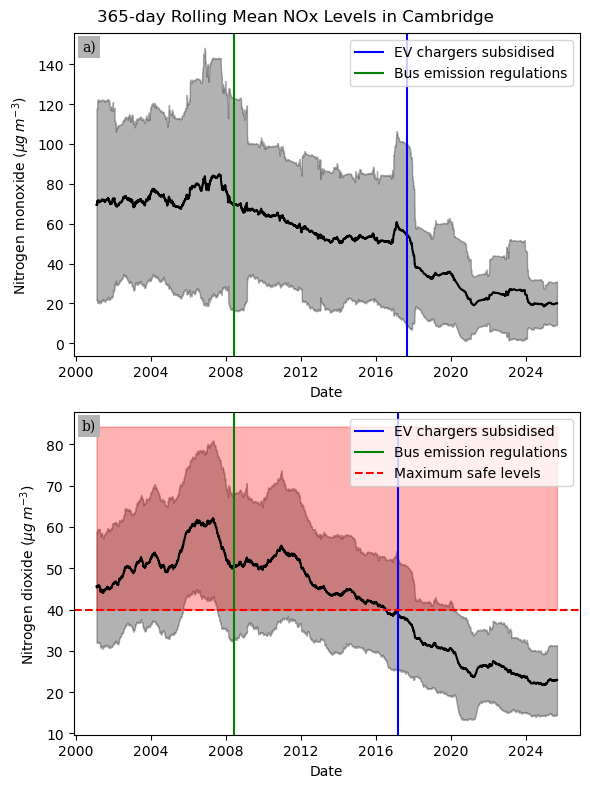

In [104]:
rm365_no = averaged[(averaged.hour == 9) & (averaged.weekday == 1)].no.rolling(window='365D').mean()[366:]
rm365_no_std = averaged[(averaged.hour == 9) & (averaged.weekday == 1)].no.rolling(window='365D').std()[366:]

rm365_no2 = averaged[(averaged.hour == 9) & (averaged.weekday == 1)].no2.rolling(window='365D').mean()[366:]
rm365_no2_std = averaged[(averaged.hour == 9) & (averaged.weekday == 1)].no2.rolling(window='365D').std()[366:]

# This figure is included in the report.
fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), nrows=2)
ax1.plot(rm365_no.index, rm365_no.values, color='black')
ax1.fill_between(rm365_no_std.index, 
                 rm365_no.values - rm365_no_std.values, 
                 rm365_no.values + rm365_no_std.values, 
                 color='black', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Nitrogen monoxide ($\mu g\: m^{-3}$)')
ax1.axvline(pd.to_datetime('2017-09-01'), color='blue', linestyle='-', label='EV chargers subsidised')
ax1.axvline(pd.to_datetime('2008-06-01'), color='green', linestyle='-', label='Bus emission regulations')
# ax1.axvline(pd.to_datetime('2020-03-23'), color='blue', linestyle='--', label='COVID-19 Lockdown Start')
ax1.legend(loc='best')
ax1.annotate(
    "a)",
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.6, -0.5), textcoords='offset fontsize',
    fontsize='medium', verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

ax2.plot(rm365_no2.index, rm365_no2.values, color='black')
ax2.fill_between(rm365_no2_std.index, 
                 rm365_no2.values - rm365_no2_std.values, 
                 rm365_no2.values + rm365_no2_std.values, 
                 color='black', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Nitrogen dioxide ($\mu g\: m^{-3}$)')
ax2.axvline(pd.to_datetime('2017-03-01'), color='blue', linestyle='-', label='EV chargers subsidised')
ax2.axvline(pd.to_datetime('2008-06-01'), color='green', linestyle='-', label='Bus emission regulations')
ax2.axhline(40, color='red', linestyle='--', label='Maximum safe levels')
plt.fill_between(rm365_no2.index, 40, ax2.get_ylim()[1], color='red', alpha=0.3)
ax2.legend(loc='upper right')
ax2.annotate(
    "b)",
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.6, -0.5), textcoords='offset fontsize',
    fontsize='medium', verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('365-day Rolling Mean NOx Levels in Cambridge')
fig.savefig('long_term.svg', format='svg')

I'm pretty happy with how these look now. Let's make one final figure: A map of all schools within a given radius of the data collected.

In [105]:
# 1. Create a map object centred at the Central Cambridge marker on Google Maps (next to Christ's College Porters' Lodge)
m = folium.Map(location=[52.2052, 0.1218], zoom_start=12.5, tiles='Cartodb Positron') # Greyscale tiles used to make data stand out more.

# 2. Add site locations as markers
site_locs = [[52.202370, 0.124456], # Cambridge Roadside
            [52.199488, 0.127661],  # Gonville Place A603
            [52.214201, 0.136545],  # Montague Road
            [52.204608, 0.125891],  # Parker Street
            [52.199575, 0.127740],  # Gonville Place
            [52.225556, 0.087222]   # Girton Road
             ]
for site in site_locs:
    folium.Circle(
        location=site,
        color='blue',
        radius=15
    ).add_to(m)

# 3. Add a circle
folium.Circle(
    location=[52.2052, 0.1218], # Location marked as 'Central Cambridge' on Google Maps
    radius=3350,  # Radius in meters out to the furthest monitoring site
    color='blue',
    fill=True,
    fill_color='blue'
).add_to(m)

# Add school locations within a given radius of Cambridge city centre
# (from https://reports.ofsted.gov.uk/search?q=&location=St+Andrew%27s+St%2C+Cambridge+CB2+3BU%2C+UK&lat=52.2049105&lon=0.1222893&radius=2&level_1_types=1&status%5B0%5D=1&start=0&rows=10
# and https://www.schoolsearch.co.uk/search/All+All+All+East%20-%20Cambridgeshire/?postcode=CB2%203BU&radius=2), radius of 2 miles
school_locs = [
    [52.204433, 0.128514],   # Parkside Community College
    [52.210554, 0.120994],   # Park Street CofE Primary School
    [52.206290, 0.134780],   # Cardiff Sixth Form College, Cambridge
    [52.193910, 0.133720],   # St Alban's Catholic Primary School
    [52.201040, 0.124980],   # St Paul's CofE VA Primary School
    [52.205610, 0.141020],   # St Matthew's Primary School
    [52.205900, 0.137700],   # Mander Portman Woodward (MPW Cambridge)
    [52.199340, 0.123630],   # Heritage School
    [52.203430, 0.132570],   # First Intuition Cambridge Limited
    [52.201890, 0.139240],   # St Andrew's College Cambridge
    [52.192980, 0.107840],   # Newnham Croft Primary School
    [52.182980, 0.142780],   # Cambridge Maths School
    [52.217400, 0.120420],   # Chesterton Community College
    [52.215480, 0.131020],   # St Luke's CofE Primary School
    [52.218420, 0.131620],   # Milton Road Primary School
    [52.217050, 0.098690],   # Castle School, Cambridge
    [52.219520, 0.108600],   # Mayfield Primary School
    [52.224120, 0.110160],   # Arbury Primary School
    [52.188151, 0.135297],   # Hills Road Sixth Form College
    [52.192740, 0.157290],   # St Philip's CofE Aided Primary School
    [52.210160, 0.150790],   # Abbey College Cambridge
    [52.229710, 0.127460],   # North Cambridge Academy
    [52.188670, 0.139560],   # Ridgefield Primary School
    [52.204640, 0.143230],   # Cambridge Muslim Secondary School
    [52.190770, 0.142140],   # Coleridge Community College
    [52.219250, 0.137530],   # Chesterton Primary School
    [52.188650, 0.144990],   # Morley Memorial Primary School
    [52.211010, 0.160020],   # The Galfrid School
    [52.226040, 0.140620],   # The Grove Primary School
    [52.220310, 0.150030],   # St Laurence Catholic Primary School
    [52.220780, 0.080420],   # University of Cambridge Primary School
    [52.188570, 0.122563],   # St Faith's
    [52.209704, 0.105830],   # St John's College School
    [52.197009, 0.121955],   # The Leys School
    [52.217175, 0.137922],   # CATS Cambridge
    [52.203742, 0.106851],   # King's College School
    [52.198106, 0.130787],   # Sancton Wood School
    [52.194910, 0.125179],   # St Mary's School, Cambridge
    [52.189563, 0.131301],   # Stephen Perse Junior School, Fitzwilliam Building
    [52.196884, 0.125227],   # Stephen Perse Senior School
    [52.187427, 0.121954],   # The Perse Prep School
]

for school in school_locs:
    folium.Circle(
        location=school,
        color='red',
        radius=15
    ).add_to(m)

# 4. Save the map as an HTML file
m.save("map.html")

Now let's quickly tot up total student numbers for each type of school in this area and use it to generate a percentage of children attending private school in Cambridge city (from https://get-information-schools.service.gov.uk/Search).

In [106]:
state_population = (694 + # Parkside Community College
                    116 + # Park Street CofE Primary School
                    211 + # St Alban's Catholic Primary School
                    152 + # St Paul's CofE VA Primary School
                    646 + # St Matthew's Primary School
                    222 + # Newnham Croft Primary School
                    80 + # Cambridge Maths School
                    1129 + # Chesterton Community College
                    94 + # St Luke's CofE Primary School
                    411 + # Milton Road Primary School
                    235 + # Castle School, Cambridge
                    400 + # Mayfield Primary School
                    381 + # Arbury Primary School
                    2500 + # Hills Road Sixth Form College (ESTIMATE)
                    227 + # St Philip's CofE Aided Primary School
                    689 + # North Cambridge Academy
                    226 + # Ridgefield Primary School
                    571 + # Coleridge Community College
                    167 + # Chesterton Primary School
                    381 + # Morley Memorial Primary School
                    248 + # The Galfrid School
                    249 + # The Grove Primary School
                    216 + # St Laurence Catholic Primary School
                    671   # University of Cambridge Primary School
)
private_population = (98  + # Cardiff Sixth Form College, Cambridge
                      159 + # Mander Portman Woodward
                      197 + # Heritage School
                      151 + # St. Andrew's College Cambridge
                      428 + # Abbey College Cambridge
                      50  + # Cambridge Muslim Secondary School (ESTIMATE)
                      553 + # St Faith's School
                      405 + # St John's College School
                      564 + # The Leys School
                      534 + # CATS Cambridge
                      390 + # King's College School
                      391 + # Sancton Wood School
                      586 + # St Mary's School, Cambridge
                      305 + # Stephen Perse Junior School (https://www.goodschoolsguide.co.uk/uk-schools/review/stephen-perse-cambridge-junior-school)
                      430 + # Stephen Perse Senior School (https://www.talkeducation.com/school/stephen-perse-senior-school/1116#:~:text=Boys%20were%20introduced%20to%20the%20school%20in,01223%20454700%20*%20A%20website%20at%20stephenperse.com)
                      280 # The Perse Prep School (https://www.perse.co.uk/admissions/prep/joining/#:~:text=Self%2Dconfidence%20and%20happiness%20are,places%20in%20each%20year%20group.&text=As%20there%20has%20been%20such,a%20strong%20desire%20to%20learn.) (ESTIMATE)
)

private_percent = private_population / (private_population + state_population) * 100
print(f"In the city of Cambridge, {private_percent:.1f}% of schoolchildren are privately educated.")

In the city of Cambridge, 33.6% of schoolchildren are privately educated.


This value of 33.6% is 5.2 times higher than the national average of 6.4% (https://explore-education-statistics.service.gov.uk/find-statistics/school-pupils-and-their-characteristics/2024-25), likely a product of Cambridge city being a reasonably affluent area, perhaps due to association with the University (complete speculation on my part). By population alone, we would therefore expect private schools to be responsible for roughly 33.6% of emissions if private school and state school students contributed equally. Returning to our regression analysis:

In [107]:
private_emissions_percent = no2_model.params['private_term'] / (no2_model.params['state_term'] + no2_model.params['private_term']) * 100
print(f"In the city of Cambridge, {private_emissions_percent:.1f}% of total NO2 emissions related to school activity are associated with independent schools.")
print(f"This amounts to an over-representation of {(private_emissions_percent / private_percent - 1) * 100:.1f}% relative to their share of the school-age population.")

In the city of Cambridge, 39.0% of total NO2 emissions related to school activity are associated with independent schools.
This amounts to an over-representation of 16.0% relative to their share of the school-age population.


## Conclusions
We have clearly shown a significant over-representation in the emissions profile of Cambridge from independent schools. Interestingly, the difference appears to be much more pronounced in PM2.5 compared to NO2, as seen below (using data taken on weekdays, during respective term times, when commuter emissions are highest*):

\*These times are determined empirically from the graphs above and differ between pollutants due to their respective atmospheric lifetimes. 

In [108]:
peak_no2_state = averaged[((averaged.weekday == 1) & (averaged.state_term == 1) & (averaged.private_term==0) & ((averaged.hour == 8) | (averaged.hour == 17)))].no2.mean()
peak_no2_both = averaged[((averaged.weekday == 1) & (averaged.private_term == 1) & ((averaged.hour == 8) | (averaged.hour == 17)))].no2.mean()
private_no2_increase = (peak_no2_both - peak_no2_state) / peak_no2_state * 100

peak_pm2_5_state = averaged[((averaged.weekday == 1) & (averaged.state_term == 1) & (averaged.private_term==0) & ((averaged.hour == 7) | (averaged.hour == 20)))].pm2_5_shifted.mean()
peak_pm2_5_both = averaged[((averaged.weekday == 1) & (averaged.private_term == 1) & ((averaged.hour == 7) | (averaged.hour == 20)))].pm2_5_shifted.mean()
private_pm2_5_increase = (peak_pm2_5_both - peak_pm2_5_state) / peak_pm2_5_state * 100

print(f"During peak commuter hours on weekdays, the presence of private school terms is associated with an\naverage increase of {private_no2_increase:.1f}% in NO2 concentration and {private_pm2_5_increase:.1f}% in PM2.5 concentration compared to state school terms alone.")

During peak commuter hours on weekdays, the presence of private school terms is associated with an
average increase of 4.2% in NO2 concentration and 12.5% in PM2.5 concentration compared to state school terms alone.


Without performing further analysis, I suspect that this is due to a higher proportion of diesel vehicles used by private school parents. Modern diesel vehicles are fitted with Diesel Particulate Filters (DPFs), but any car not conforming to Euro 5 (2009) standards, or those with damaged DPFs, would emit much greater levels of PM2.5 compared to a petrol car. Diesel manufacturers have been known to incorporate "defeat devices" to mask high pollutant levels at the exhaust pipe (see "Dieselgate").